In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, BatchNormalization, Dropout 
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt, gc
import seaborn as sns
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 
import random 
from sklearn.metrics import confusion_matrix, classification_report 

pd.set_option('display.max_columns', None) 

/Users/aaryanmehta/miniforge3/envs/env_tf/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# Preprocessing function 

def feature_engineer(file_path, PAD_CUSTOMER_TO_13_ROWS = True):

    train = pd.read_csv(file_path)
        
    # REDUCE STRING COLUMNS 
    # from 64 bytes to 8 bytes, and 10 bytes to 3 bytes respectively
    train['customer_ID'] = train['customer_ID'].str[-16:].apply(lambda x: int(x, 16)).astype('int64')
    train.S_2 = pd.to_datetime( train.S_2 )
    train['year'] = (train.S_2.dt.year-2000).astype('int8')
    train['month'] = (train.S_2.dt.month).astype('int8')
    train['day'] = (train.S_2.dt.day).astype('int8')
    del train['S_2']
        
        
    # LABEL ENCODE CAT COLUMNS (and reduce to 1 byte)
    # with 0: padding, 1: nan, 2,3,4,etc: values
    d_63_map = {'CL':2, 'CO':3, 'CR':4, 'XL':5, 'XM':6, 'XZ':7}
    train['D_63'] = train.D_63.map(d_63_map).fillna(1).astype('int8')

    d_64_map = {'-1':2,'O':3, 'R':4, 'U':5}
    train['D_64'] = train.D_64.map(d_64_map).fillna(1).astype('int8')
    
    CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
    OFFSETS = [2,1,2,2,3,2,3,2,2] #2 minus minimal value in full train csv
    # then 0 will be padding, 1 will be NAN, 2,3,4,etc will be values
    for c,s in zip(CATS,OFFSETS):
        train[c] = train[c] + s
        train[c] = train[c].fillna(1).astype('int8')
    CATS += ['D_63','D_64']
            

    # PAD ROWS SO EACH CUSTOMER HAS 13 ROWS
    if PAD_CUSTOMER_TO_13_ROWS:
        tmp = train[['customer_ID']].groupby('customer_ID').customer_ID.agg('count')
        more = np.array([],dtype='int64') 
        for j in range(1,13):
            i = tmp.loc[tmp==j].index.values
            more = np.concatenate([more,np.repeat(i,13-j)])

        df = train.iloc[:len(more)].copy().fillna(0)
        df = df * 0 - 1 #pad numerical columns with -1
        df[CATS] = (df[CATS] * 0).astype('int8') #pad categorical columns with 0
        df = pd.DataFrame({'customer_ID':more})
        train = pd.concat([train,df],axis=0,ignore_index=True)

    # FILL NAN
    cols_with_nulls = [col for col in train.columns if col != 'target' and train[col].isnull().any()]
    train[cols_with_nulls] = train[cols_with_nulls].fillna(-0.5)
    train['target'] = train['target'].fillna(1)

    
    # SORT BY CUSTOMER THEN DATE
    train = train.sort_values(['customer_ID','year','month','day']).reset_index(drop=True)
    train = train.drop(['year','month','day'],axis=1)
    
    # REARRANGE COLUMNS WITH 11 CATS FIRST
    COLS = list(train.columns[1:])
    COLS = ['customer_ID'] + CATS + [c for c in COLS if c not in CATS]
    train = train[COLS]

    X = train.drop(columns=['target'])
    y = train[['target']]
    
    return X, y 

In [3]:
# Load the files sequentially to avoid memory errors

directory_path = r".../input" #PATH OF THE DIRECTORY WHERE THE FILES ARE STORED AFTER RUNNING SPLIT_TRAIN.IPYNB

X_list = []
y_list = []
number_of_files = 22 #CHANGE THIS VARIABLE TO THE NO. OF FILES CREATED AFTER RUNNING SPLIT_TRAIN.IPYNB

for i in range(number_of_files):
    file = 'output_' + str(i) + '.csv'
    File_Path = directory_path + '/' + file
    print("Processing", file)
    X, y = feature_engineer(File_Path)
    X_list.append(X)
    y_list.append(y) 

Processing output_0.csv
Processing output_1.csv
Processing output_2.csv
Processing output_3.csv
Processing output_4.csv
Processing output_5.csv
Processing output_6.csv
Processing output_7.csv
Processing output_8.csv
Processing output_9.csv
Processing output_10.csv
Processing output_11.csv
Processing output_12.csv
Processing output_13.csv
Processing output_14.csv
Processing output_15.csv
Processing output_16.csv
Processing output_17.csv
Processing output_18.csv
Processing output_19.csv
Processing output_20.csv
Processing output_21.csv


In [4]:
# Concatenate the data from all the files

X_final = pd.concat(X_list)
y_final = pd.concat(y_list) 

In [5]:
print(y_final.value_counts()) 

target
0.0       4507527
1.0       1964055
dtype: int64


In [6]:
# Feature Engineering Function 

def feature_engineering(no_of_files, X_final):

    imp_features_across_files = []
    for i in range(no_of_files):
        file = 'output_' + str(i) + '.csv'
        File_Path = directory_path + '/' + file
        
        A = pd.read_csv(File_Path)
        corr = A.corr()['target'] 

        # Sort the features by their correlation with the target variable
        corr = corr.sort_values(ascending=False)
        imp_features_across_files.extend(corr.index[1:31])

    # Remove duplicate entries 
    imp_features_across_files = list(set(imp_features_across_files))

    X_final = X_final[['customer_ID'] + imp_features_across_files[:100]]
    
    return X_final 

In [7]:
X_final = feature_engineering(number_of_files, X_final) 

In [8]:
# Split the data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, shuffle=False, test_size=0.2) 

In [9]:
# Scaling the Data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [10]:
# Creating the GRU Model  

model = Sequential()

model.add(GRU(64, input_shape=(X_train_scaled.shape[1], 1), activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(GRU(32, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid')) 

model.summary() 

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-01 15:59:54.709131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-01 15:59:54.711108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 33, 64)            12864     
                                                                 
 dropout (Dropout)           (None, 33, 64)            0         
                                                                 
 batch_normalization (BatchN  (None, 33, 64)           256       
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [11]:
# Create the ModelCheckpoint callback to save the best performing model

filepath = "../input/checkpoint.hd5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') 


In [ ]:
# Learning rate callback

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2) 

In [12]:
# Creating a custom loss function that can deal with unbalanced dataset

def focal_loss(gamma, alpha):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(K.epsilon()+pt_1)) \
               -K.mean((1-alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed 

In [13]:
# Initialising the optimizer and loss function

opt = tf.keras.optimizers.Adam()

model.compile(loss=focal_loss(gamma=2, alpha=0.303), optimizer=opt, metrics=['accuracy']) 

In [14]:
gc.collect() 

28792

In [15]:
history = model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1),
                    y_train,
                    batch_size=32,
                    epochs=5,
                    validation_split=0.2,                        
                    callbacks =[checkpoint],
                    verbose=1) 

Epoch 1/5


32358/32358 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.8276


Epoch 1: val_loss improved from inf to 0.03486, saving model to credNet_(no_generator).hd5


INFO:tensorflow:Assets written to: credNet_(no_generator).hd5/assets


32358/32358 [==============================] - 1581s 49ms/step - loss: 0.0358 - accuracy: 0.8276 - val_loss: 0.0349 - val_accuracy: 0.8188
Epoch 2/5
32358/32358 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.8345
Epoch 2: val_loss improved from 0.03486 to 0.03335, saving model to credNet_(no_generator).hd5


INFO:tensorflow:Assets written to: credNet_(no_generator).hd5/assets


32358/32358 [==============================] - 1595s 49ms/step - loss: 0.0344 - accuracy: 0.8345 - val_loss: 0.0334 - val_accuracy: 0.8469
Epoch 3/5
32358/32358 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.8381
Epoch 3: val_loss improved from 0.03335 to 0.03315, saving model to credNet_(no_generator).hd5


INFO:tensorflow:Assets written to: credNet_(no_generator).hd5/assets


32358/32358 [==============================] - 1272s 39ms/step - loss: 0.0339 - accuracy: 0.8381 - val_loss: 0.0331 - val_accuracy: 0.8356
Epoch 4/5
32358/32358 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.8379
Epoch 4: val_loss improved from 0.03315 to 0.03290, saving model to credNet_(no_generator).hd5


INFO:tensorflow:Assets written to: credNet_(no_generator).hd5/assets


32358/32358 [==============================] - 1622s 50ms/step - loss: 0.0340 - accuracy: 0.8379 - val_loss: 0.0329 - val_accuracy: 0.8424
Epoch 5/5
32358/32358 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.8377
Epoch 5: val_loss did not improve from 0.03290
32358/32358 [==============================] - 2068s 64ms/step - loss: 0.0339 - accuracy: 0.8377 - val_loss: 0.0331 - val_accuracy: 0.8381


In [16]:
gc.collect() 

369170

In [17]:
model.save('.../input/CredNet.hd5') 

INFO:tensorflow:Assets written to: /Users/aaryanmehta/Desktop/BE Project/notebooks/credNet_(no_generator).hd5/assets


INFO:tensorflow:Assets written to: /Users/aaryanmehta/Desktop/BE Project/notebooks/credNet_(no_generator).hd5/assets


In [18]:
# Performance per epoch 

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch 
hist 

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.035773,0.827640,0.034864,0.818818,0
1,0.034427,0.834521,0.033352,0.846911,1
2,0.033905,0.838147,0.033146,0.835557,2
3,0.033968,0.837919,0.032900,0.842439,3
4,0.033869,0.837707,0.033059,0.838054,4


In [19]:
# Visualizing the performance per epoch

accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss'] 

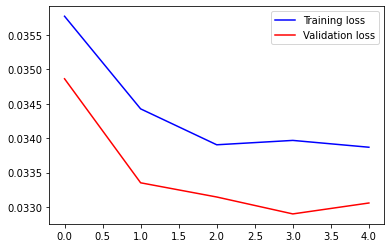

In [20]:
# Visualizing the training and validation loss per epoch

epochs = range(len(accuracy))

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.legend()

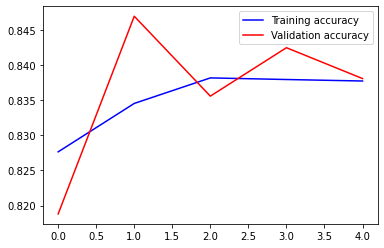

In [21]:
# Visualizing the training and validation accuracies per epoch

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'blue', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'red', label='Validation accuracy')
plt.legend()

In [22]:
gc.collect() 

364694

In [23]:
# Load the saved model

loaded_model = load_model('.../input/credNet.hd5', custom_objects={'focal_loss_fixed': focal_loss}) 

In [24]:
# Make predictions on the test data

test_preds = loaded_model.predict(X_test_scaled) 

2023-05-01 22:58:54.097244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-01 22:58:54.297613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-01 22:58:54.415653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [29]:
test_binary_preds = np.where(test_preds >= 0.5, 1, 0) 
 
a = 0
b = 0

length = len(test_binary_preds)
for i in range(length):
    if test_binary_preds[i]==0:
        a = a+1
    else:
        b = b+1

print("0 =", a)
print("1 =", b) 

0 = 1060620
1 = 233697


In [26]:
print(y_test.value_counts()) 

target
0.0       904472
1.0       389845
dtype: int64


In [34]:
# Generate the classification report

report = classification_report(y_test, test_binary_preds)
print(report) 

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89    904472
         1.0       0.89      0.53      0.67    389845

    accuracy                           0.84   1294317
   macro avg       0.86      0.75      0.78   1294317
weighted avg       0.85      0.84      0.83   1294317



<AxesSubplot:>

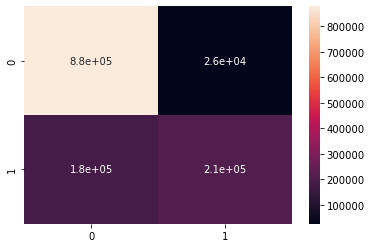

In [35]:
# Generate the confusion matrix

CM = confusion_matrix(y_test, test_binary_preds)
sns.heatmap(CM, annot=True) 